# MF-DFA for MMS1 Data 
This notebook contains the functions necessary to perform Multifractal Detrended Fluctuation Analysis

In [173]:
#Imports:
from MFDFA import MFDFA
import pyspedas
import matplotlib.pyplot as plt
import numpy as np
from pyspedas import tplot

For this notebook, we are using the ``Pyspedas`` library to load the MMS1 data, and ``MFDFA`` library to perform a multifractal analysis

29-Dec-24 14:26:21: Loading pydata/mms1/fgm/srvy/l2/2024/03/mms1_fgm_srvy_l2_20240310_v5.442.0.cdf


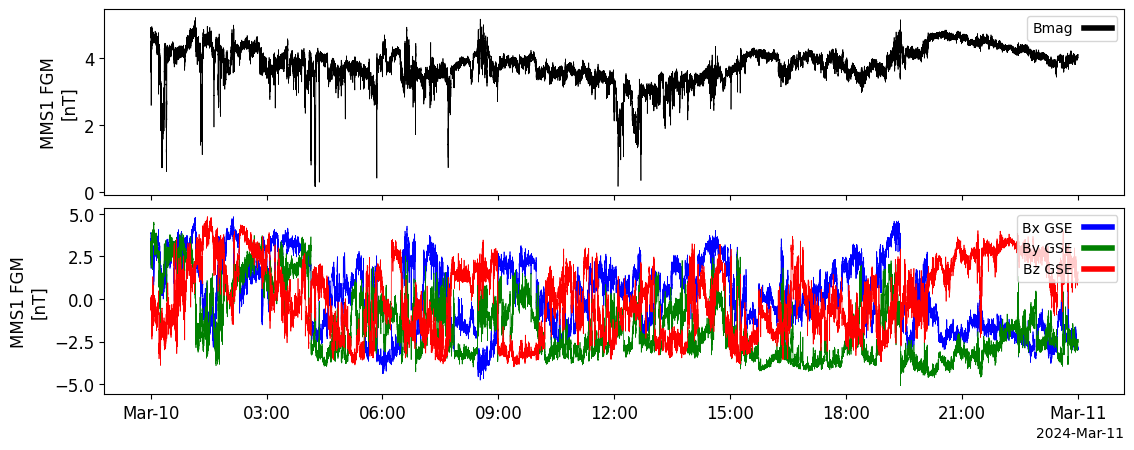

loaded data!


In [174]:
#Here we gather the MMS1 data using Pyspedas:
pyspedas.mms.fgm(time_clip=True,probe=1,trange=["2024-03-10","2024-03-11"])

#Plot the data: 
t_plot=tplot(['mms1_fgm_b_gse_srvy_l2_btot', 'mms1_fgm_b_gse_srvy_l2_bvec'])

#Get data to be put in array format:
magdata=pyspedas.get_data("mms1_fgm_b_gse_srvy_l2_btot")

#extract time and B-field magnitudes:
times=magdata.times
bmag=magdata.y

print("loaded data!")

**MF-DFA: Fluctuation Function**\
\
One of the first steps of performing MF-DFA is calculating the fluctuation function of the data. We need to define a few equations before we can get to this step, which is handled by the MF-DFA library.

1. A cumulative sum is first performed, defined as follows:


For a time series $x_k$, $k=1,2,...,N$:


$Y(i)=\sum_{k=1}^i[x_k-\langle x \rangle]$, for $i=1,...,N$


$Y(i)$ is then divided into $N_s=int(N/s)$ segments with length $s$. This is repeated backwards from the end of $Y(i)$, to the beginning, in order to gather all the data points. Finally, the polynomial fit of each section indexed by segment $\nu$ is taken, which gives a polynomial equation $y_\nu(i)$


2. Once this is calculated, the variance is described by the following equation: 


$F^2(s,\nu)=\frac{1}{s}\sum_{i=1}^s\{Y[(\nu-1)s+i]-y_\nu(i)\}$

for each segment indexed by $\nu=1,...,N_s$.

For each segment indexed by $\nu=N_s+1,...,2N_s$, we have:

$F^2(s,\nu)=\frac{1}{s}\sum_{i=1}^s\{Y[N-(\nu-N_s)s+i]-y_\nu(i)\}$.

3. Finally, we take the average of all segments in the variance, which gives us the q-th order fluctuation function. For our purposes, we are using $q=2$ to obtain the DFA method. This gives us the following equation:

$F_q(s)=\{\frac{1}{2N_s}\sum_{\nu=1}^{2N_s}[F^2(s,\nu)]^{q/2}\}^{q/2}$.

If we find the log plot of the fluctuation function, and then linearly fit the log of that plot, the slope returns the Hurst parameter.

We then need to repeat this process for different time scales. Luckily, the MF-DFA library for Python handles this all for us with a defined set of lags corresponding to the time scales in the function MFDFA(), which returns the fluctuation function.



In [175]:
#Our first helper function will allow us to find the fluctuation function
#of our data, as described in the Gomes article.


#Here, "order" represents the order of the polynomial fitting,
# "qList" represents the list of powers of the fluctuation function, (q=2 for a monofractal case)
# "lag" represents the list of lags as a series of integers that represent side lengths
# bmag is the total magnitude of the magnetic field data

def flucFunc(bmag, lag, qList, order):
    # Here we use the MFDFA function to give us the fluctuation function ,
    # which we then take the log of:
    lag, dfaList = MFDFA(bmag, lag=lag, q=qList, order=order)
    
    #Obtain the log-log plot which has a slope of the log of the Hurst parameter:
    for dfa in dfaList:
        plt.loglog(lag,dfaList,'o')
        
        #label=f'fOU: MFDFA {qList[i]}=2'
    plt.xlabel(r'lag $s$')
    plt.ylabel(r'$F_q(s)$')
    plt.show()
    
    return lag,dfaList

**MF-DFA: Hurst Parameter**

Now that we have the fluctuation function, we can calculate the Hurst parameter. This is simply the slope of the double log of our fluctuation function. We have already obtained the log-log plot of the fluctuation function, so we only need to take the log one more time, and perform a linear fit to find the Hurst parameter.


In [170]:
# We also need a list of the Hurst parameters for varying q values:
def hList(lag,dfaList):
    # Initialize an empty list to hold our Hurst parameters:
    hList=[]
    
    # For every q in out list of powers, we need to find the Hurst parameter:
    for dfa in dfaList:
        # From the slope we obtain: slope = H + 1, so H = slope - 1
        # We fit to a 1st degree polynomial for a linear fit
        H=np.polyfit(np.log(lag)[2:9],np.log(dfa[2:9]),1)[0]
        print(np.polyfit(np.log(lag)[2:9],np.log(dfa[2:9]),1)[0])
        print('Estimated H = '+'{:.3f}'.format(H))

        hList.append(H)
    

    return hList

**MF-DFA: Renyi Exponents**

Once $F_q(s)$ is found for a ragnge of $q$ values, we can find the Renyi exponents, which are related to the multifractal spectrum by a Legendre transform. The Renyi exponents are calculated from the Hurst parameter by the following relation:

$\tau(q)=qh(q)-1$.

In [148]:
# To find the Renyi exponents, we first need a list of Hurst parameters
# associated with q values.
def renyiExp(qList,hList):
    #Initialize an empty list to hold the Renyi exponents:
    tauList=[]
    
    # Now, for each q and H, we can calculate the Renyi exponent defined by
    # the above equation 
    for i in range(len(qList)):
        # Here we apply the relation of the Hurst parameter to the Renyi exponent:
        tauList.append(qList[i]*hList[i]-1)
    
    # Plot the resulting spectrum:
    plt.plot(qList,tauList,'o')
    plt.xlabel(r'$q$')
    plt.ylabel(r'$\tau(q)$')
    plt.show()
    
    return tauList        

[  1   2   4   8  16  32  64 128 256 512]
[-20.0, -19.75, -19.5, -19.25, -19.0, -18.75, -18.5, -18.25, -18.0, -17.75, -17.5, -17.25, -17.0, -16.75, -16.5, -16.25, -16.0, -15.75, -15.5, -15.25, -15.0, -14.75, -14.5, -14.25, -14.0, -13.75, -13.5, -13.25, -13.0, -12.75, -12.5, -12.25, -12.0, -11.75, -11.5, -11.25, -11.0, -10.75, -10.5, -10.25, -10.0, -9.75, -9.5, -9.25, -9.0, -8.75, -8.5, -8.25, -8.0, -7.75, -7.5, -7.25, -7.0, -6.75, -6.5, -6.25, -6.0, -5.75, -5.5, -5.25, -5.0, -4.75, -4.5, -4.25, -4.0, -3.75, -3.5, -3.25, -3.0, -2.75, -2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75,

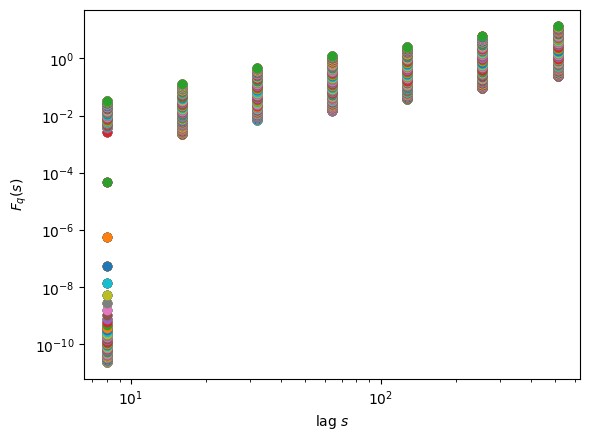

[[2.37784893e-11 2.39679727e-11 2.41637986e-11 ... 3.31395049e-02
  3.34068347e-02 3.36697268e-02]
 [2.18956546e-03 2.20540444e-03 2.22176092e-03 ... 1.25578487e-01
  1.26590116e-01 1.27584065e-01]
 [7.04725279e-03 7.08903793e-03 7.13187839e-03 ... 4.52021432e-01
  4.55365653e-01 4.58651271e-01]
 ...
 [3.79658245e-02 3.81524693e-02 3.83439615e-02 ... 2.52481015e+00
  2.54102410e+00 2.55695534e+00]
 [9.08825543e-02 9.12860202e-02 9.17001060e-02 ... 5.82011841e+00
  5.84849334e+00 5.87632068e+00]
 [2.37298238e-01 2.38373769e-01 2.39478006e-01 ... 1.30884792e+01
  1.31490531e+01 1.32085020e+01]]
1.2738863327100882
Estimated H = 1.274
1.273345448304718
Estimated H = 1.273
1.2727976740715319
Estimated H = 1.273
1.272243201442008
Estimated H = 1.272
1.2716822558507892
Estimated H = 1.272
1.2711150997234602
Estimated H = 1.271
1.2705420356618804
Estimated H = 1.271
1.2699634098365555
Estimated H = 1.270
1.2693796155961168
Estimated H = 1.269
1.2687910973047292
Estimated H = 1.269
1.2681983544

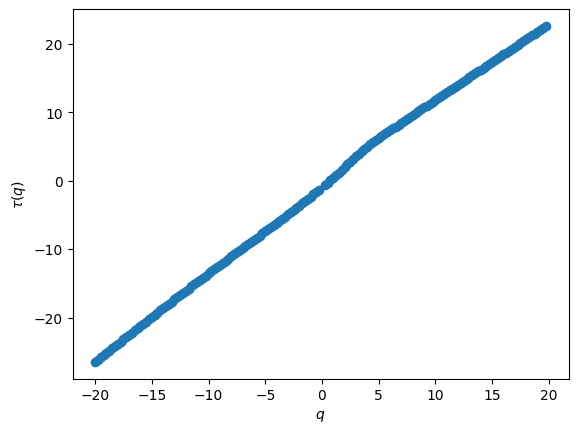

In [172]:
#  This is the main function we will use to run our helper functions:
def main():
    # We first need to select a band of lags, varying from small segments of data to long ones:
    # These bands must be integers, since they will segment the data into chunks of side length s:
    #lag=np.unique(np.logspace(0.5,3,100,dtype=int))
    lag=np.power(2,range(10),dtype=int)
    print(lag)
    # We need to select a range of powers for the fluctuation function.
    # Gomes et al. do -20 to 20 with increments of 0.25
    qList=np.arange(-20,20,0.25).tolist()
    qList.remove(0)
    print(qList)
    #The order for the polynomial fitting is chosen by Gomes et al. as 3:
    
    order=3
    lag,dfaList=flucFunc(bmag,lag,qList,order)
    print(dfaList)
    #hurstParameter(lag,dfaList.T)
    
    h=hList(lag,dfaList.T)
    
    tauFunc=renyiExp(qList,h)

    
main()